In [1]:
# Task 4: image to image translation with cGAN


!wget -O facades.tar.gz https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz


--2025-12-11 15:46:35--  https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  70.9MB/s    in 0.4s    

2025-12-11 15:46:35 (70.9 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [ ]:
!ls facades/train | head


100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
105.jpg
106.jpg
107.jpg
108.jpg
109.jpg


--2025-12-07 10:20:36--  https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  13.5MB/s    in 2.1s    

2025-12-07 10:20:39 (13.5 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

Dataset Downloaded and Extracted.
Dataset Loaded Successfully!
Training...
Training Completed!


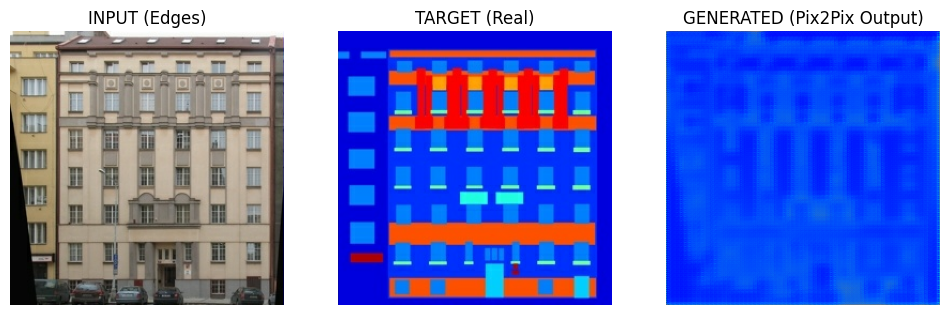

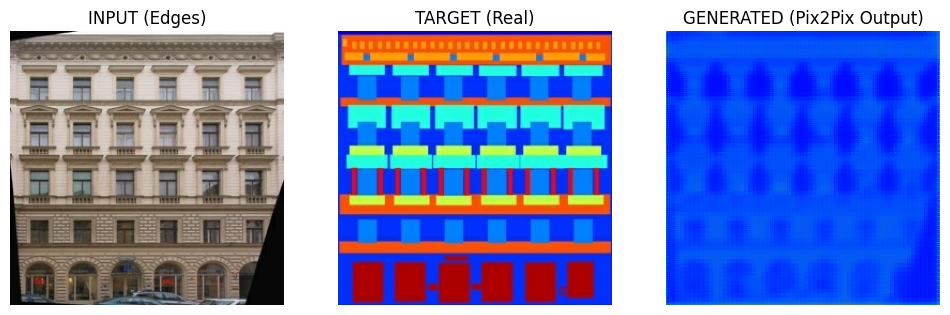

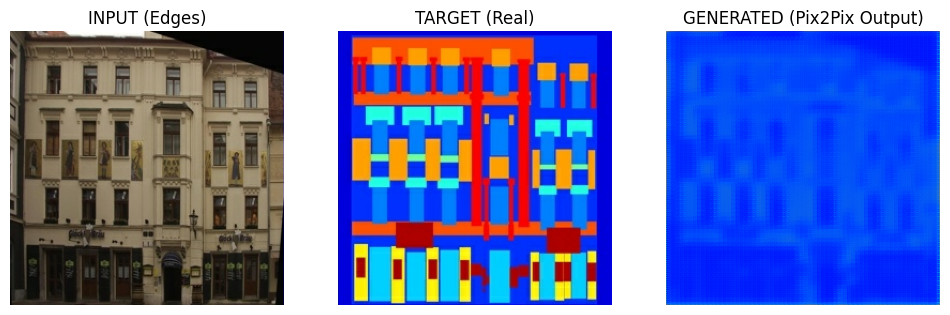

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import glob

!wget -O facades.tar.gz https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

print("Dataset Downloaded and Extracted.")

def load_image(path):
    path = tf.cast(path, tf.string)
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)

    w = tf.shape(img)[1] // 2
    input_img = img[:, :w, :]
    target_img = img[:, w:, :]

    input_img = tf.image.resize(input_img, (256,256))
    target_img = tf.image.resize(target_img, (256,256))

    input_img = (tf.cast(input_img, tf.float32) / 127.5) - 1
    target_img = (tf.cast(target_img, tf.float32) / 127.5) - 1

    return input_img, target_img

train_paths = sorted(glob.glob("facades/train/*.jpg"))
test_paths  = sorted(glob.glob("facades/test/*.jpg"))

train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(load_image).batch(1)

test_ds  = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds  = test_ds.map(load_image).batch(1)

print("Dataset Loaded Successfully!")

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)

generator = Generator()

def Discriminator():
    inp = layers.Input(shape=[256,256,3])
    tar = layers.Input(shape=[256,256,3])

    x = layers.Concatenate()([inp, tar])
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 4, padding='same')(x)

    return tf.keras.Model([inp, tar], x)

discriminator = Discriminator()

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt  = tf.keras.optimizers.Adam(2e-4)
disc_opt = tf.keras.optimizers.Adam(2e-4)
LAMBDA = 100

@tf.function
def train_step(inp, tar):
    with tf.GradientTape() as gt, tf.GradientTape() as dt:

        fake = generator(inp, training=True)

        real_out = discriminator([inp, tar], training=True)
        fake_out = discriminator([inp, fake], training=True)

        gen_loss_gan = loss_obj(tf.ones_like(fake_out), fake_out)
        gen_loss_l1  = tf.reduce_mean(tf.abs(tar - fake))
        gen_loss = gen_loss_gan + LAMBDA * gen_loss_l1

        disc_loss = loss_obj(tf.ones_like(real_out), real_out) + \
                    loss_obj(tf.zeros_like(fake_out), fake_out)

    g_grad = gt.gradient(gen_loss, generator.trainable_variables)
    d_grad = dt.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(g_grad, generator.trainable_variables))
    disc_opt.apply_gradients(zip(d_grad, discriminator.trainable_variables))

print("Training...")

for inp, tar in train_ds.take(100):  # only 100 samples to be fast
    train_step(inp, tar)

print("Training Completed!")

def show_results(model, dataset):
    for inp, tar in dataset.take(3):
        pred = model(inp, training=False)[0]

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title("INPUT (Edges)")
        plt.imshow((inp[0]*0.5+0.5))
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("TARGET (Real)")
        plt.imshow((tar[0]*0.5+0.5))
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("GENERATED (Pix2Pix Output)")
        plt.imshow((pred*0.5+0.5))
        plt.axis('off')

        plt.show()

show_results(generator, test_ds)
